In [1]:
import numpy
import fiona
import pandas
import geopandas
from image_processing import contrast
from image_processing.segmentation import Segments, rasterise_vector
import matplotlib.pyplot as plt
import datacube
from datacube.storage import masking
dc = datacube.Datacube(app='dc-example')
%matplotlib inline

### Query the datacube

Open the vector file and get the bounding box

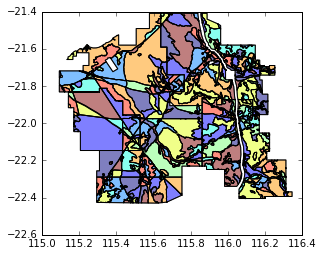

In [2]:
vfname = '/g/data/v10/testing_ground/jps547/pilbara/CaneRiver_Nanutarra_MtMinnie_Peedamulla_RedHill_Yarraloola_Merge_WGS84_LandSystemType.shp'
src = fiona.open(vfname, 'r')
xidx = (src.bounds[0], src.bounds[2])
yidx = (src.bounds[-1], src.bounds[1])
gdf = geopandas.read_file(vfname)
gdf.plot()

In [3]:
print xidx
print yidx
xidx = (115.1, 115.9)
yidx = (-22.1, -22.5)
print xidx
print yidx

(115.09331703186035, 116.34464454650879)
(-21.409351348235056, -22.429670349333843)
(115.1, 115.9)
(-22.1, -22.5)


Using the co-ordinates of the vector file's bunding box, query the datacube.

In [4]:
nbar_ls5 = dc.load(product='ls5_nbar_albers', x=xidx, y=yidx, time=('2005-04', '2006-04'), group_by='solar_day')

In [5]:
pq_ls5 = dc.load(product='ls5_pq_albers', x=xidx, y=yidx, time=('2005-04', '2006-04'), group_by='solar_day')

In [6]:
nbar_ls5 = nbar_ls5.sel(time=pq_ls5.time)

In [7]:
nbar_ls5.nbytes / 1024.0 / 1024.0 / 1024.0

2.043821834027767

In [8]:
mask = masking.make_mask(pq_ls5, ga_good_pixel=True)

In [9]:
nbar_ls5 = nbar_ls5.where(mask.pixelquality)

Determine the pixel size in hectares.  We'll use this later on.

In [10]:
ha = nbar_ls5.affine.a **2 / 10000.0
print "Pixel area in hectares: {}".format(ha)

Pixel area in hectares: 0.0625


In [11]:
dims = nbar_ls5.dims

In [12]:
def get_rgb(dataset, bands, time, window=None, percent=2):
    if window is None:
        dset_subs = dataset[bands].sel(time=time)
    else:
        xs, ys = (window[1][0], window[0][0]) * dataset.affine
        xe, ye = (window[1][1], window[0][1]) * dataset.affine
        dset_subs = dataset[bands].sel(time=time, x=slice(xs, xe), y=slice(ys, ye))
    dims = dset_subs.dims
    rgb = numpy.zeros((dims['y'], dims['x'], 3), dtype='uint8')
    for i, band in enumerate(bands):
        rgb[:, :, i] = contrast.linear_percent(dset_subs[band].values, percent=percent)
    return rgb

In [13]:
nbar_ls5.time.values

array(['2005-04-12T00:00:00.000000000', '2005-04-28T00:00:00.000000000',
       '2005-05-14T00:00:00.000000000', '2005-05-23T00:00:00.000000000',
       '2005-06-08T00:00:00.000000000', '2005-06-15T00:00:00.000000000',
       '2005-06-24T00:00:00.000000000', '2005-07-01T00:00:00.000000000',
       '2005-07-17T00:00:00.000000000', '2005-08-02T00:00:00.000000000',
       '2005-09-28T00:00:00.000000000', '2005-10-05T00:00:00.000000000',
       '2005-10-14T00:00:00.000000000', '2005-10-30T00:00:00.000000000',
       '2005-11-06T00:00:00.000000000', '2005-11-15T00:00:00.000000000',
       '2005-11-22T00:00:00.000000000', '2006-01-25T00:00:00.000000000',
       '2006-02-03T00:00:00.000000000', '2006-02-10T00:00:00.000000000',
       '2006-02-19T00:00:00.000000000', '2006-02-26T00:00:00.000000000',
       '2006-03-07T00:00:00.000000000', '2006-03-14T00:00:00.000000000'], dtype='datetime64[ns]')

/home/547/jps547/.local/lib/python2.7/site-packages/idl_functions/idl_histogram.py:186: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  hist = numpy.zeros(nbins_, dtype='uint32')


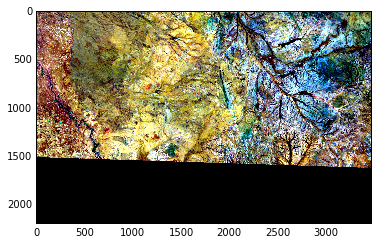

In [14]:
rgb = get_rgb(nbar_ls5, ['swir1', 'red', 'green'], '2006-02-19', percent=5)
plt.imshow(rgb)

### Segmentation

Rasterise all the geometry contained within the vector file, and create a **Segments** object.

In [15]:
ras = rasterise_vector(vfname, shape=(dims['y'], dims['x']), crs=nbar_ls5.crs.wkt, transform=nbar_ls5.affine)
seg = Segments(ras)
print "Number of segments: {}".format(seg.n_segments)

Number of segments: 131


/home/547/jps547/.local/lib/python2.7/site-packages/idl_functions/idl_histogram.py:236: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ri = numpy.zeros(ri_sz, dtype='uint32')


For the all spectral bands, calculate statistics for every segment at every timeslice

In [16]:
spectra = nbar_ls5.data_vars.keys()
zonal_stats = pandas.DataFrame()
for ts in nbar_ls5.time:
    spectra_stats = pandas.DataFrame(columns=['Segment_IDs'])
    for sp in spectra:
        data = nbar_ls5[sp].sel(time=ts).values
        df = seg.basic_statistics(data, nan=True, scale_factor=ha, dataframe=True, label=sp)
        spectra_stats = pandas.merge(spectra_stats, df, on='Segment_IDs', how='outer')
    spectra_stats['timestamp'] = ts.values
    zonal_stats = zonal_stats.append(spectra_stats)
zonal_stats.set_index('timestamp', inplace=True)

/g/data/v10/public/modules/agdc-py2-env/20160726/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/g/data/v10/public/modules/agdc-py2-env/20160726/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/g/data/v10/public/modules/agdc-py2-env/20160726/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/g/data/v10/public/modules/agdc-py2-env/20160726/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [17]:
seg.ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  15,  16,  24,
        25,  26,  27,  28,  29,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  79,  80,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 119, 120, 122, 123, 124, 125, 126, 127,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 184, 188, 189, 191, 197, 198, 202, 203, 204, 205, 207, 209])

In [18]:
gdf.iloc[2]

AREA                                                2.52204e+06
AggLandTyp                                  Spinifex grasslands
FID_CaneRi                                                    0
FID_Landsy                                                  308
FenceID                                          ex Mt Minnie_1
Land_type_                Stony plains with spinifex grasslands
LeaseName                                          ex Mt Minnie
NamAgLanTy                     ex Mt Minnie_Spinifex grasslands
NameLandTy    ex Mt Minnie_Stony plains with spinifex grassl...
geometry      POLYGON ((115.4354628266847 -22.05387893656482...
Name: 2, dtype: object

In [19]:
zonal_stats.head(4)

,Segment_IDs,blue_Mean,blue_Max,blue_Min,blue_StdDev,blue_Total,blue_Area,green_Mean,green_Max,green_Min,...,swir1_Min,swir1_StdDev,swir1_Total,swir1_Area,swir2_Mean,swir2_Max,swir2_Min,swir2_StdDev,swir2_Total,swir2_Area
timestamp,,,,,,,,,,,,,,,,,,,,,
2005-04-12,1,1592.753492,2337.0,670.0,307.879852,6500027.0,369.2500,2040.602303,2780.0,1134.0,...,3621.0,288.695560,1.965092e+07,369.2500,4035.920118,5072.0,2738.0,340.807980,1.647059e+07,369.2500
2005-04-12,2,777.045305,4260.0,10.0,333.825517,255676656.0,30756.3125,1202.021858,7377.0,10.0,...,1498.0,847.722158,1.285181e+09,30756.3125,3284.336473,5402.0,1060.0,779.503804,1.080668e+09,30756.3125
2005-04-12,3,NaN,NaN,NaN,NaN,0.0,152.7500,NaN,NaN,NaN,...,NaN,NaN,0.000000e+00,152.7500,NaN,NaN,NaN,NaN,0.000000e+00,152.7500
2005-04-12,4,NaN,NaN,NaN,NaN,0.0,36.5000,NaN,NaN,NaN,...,NaN,NaN,0.000000e+00,36.5000,NaN,NaN,NaN,NaN,0.000000e+00,36.5000


In [20]:
df = zonal_stats[zonal_stats['Segment_IDs'] == 2]

In [21]:
mean_cols = [col for col in df.columns if 'Mean' in col]
max_cols = [col for col in df.columns if 'Max' in col]
min_cols = [col for col in df.columns if 'Min' in col]
stdv_cols = [col for col in df.columns if 'StdDev' in col]

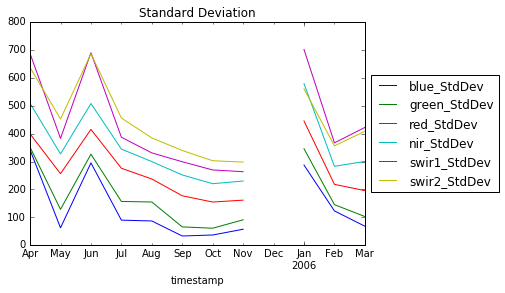

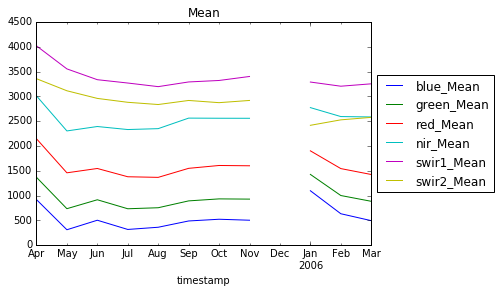

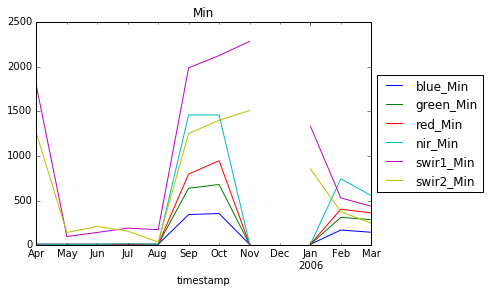

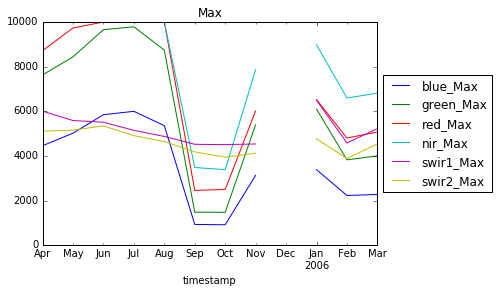

In [22]:
df[stdv_cols].resample('M').mean().plot(title='Standard Deviation').legend(loc='center left', bbox_to_anchor=(1, 0.5))
df[mean_cols].resample('M').mean().plot(title='Mean').legend(loc='center left', bbox_to_anchor=(1, 0.5))
df[min_cols].resample('M').mean().plot(title='Min').legend(loc='center left', bbox_to_anchor=(1, 0.5))
df[max_cols].resample('M').mean().plot(title='Max').legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [23]:
bboxes = seg.bounding_box()

In [24]:
nbar_ls5.time.values

array(['2005-04-12T00:00:00.000000000', '2005-04-28T00:00:00.000000000',
       '2005-05-14T00:00:00.000000000', '2005-05-23T00:00:00.000000000',
       '2005-06-08T00:00:00.000000000', '2005-06-15T00:00:00.000000000',
       '2005-06-24T00:00:00.000000000', '2005-07-01T00:00:00.000000000',
       '2005-07-17T00:00:00.000000000', '2005-08-02T00:00:00.000000000',
       '2005-09-28T00:00:00.000000000', '2005-10-05T00:00:00.000000000',
       '2005-10-14T00:00:00.000000000', '2005-10-30T00:00:00.000000000',
       '2005-11-06T00:00:00.000000000', '2005-11-15T00:00:00.000000000',
       '2005-11-22T00:00:00.000000000', '2006-01-25T00:00:00.000000000',
       '2006-02-03T00:00:00.000000000', '2006-02-10T00:00:00.000000000',
       '2006-02-19T00:00:00.000000000', '2006-02-26T00:00:00.000000000',
       '2006-03-07T00:00:00.000000000', '2006-03-14T00:00:00.000000000'], dtype='datetime64[ns]')

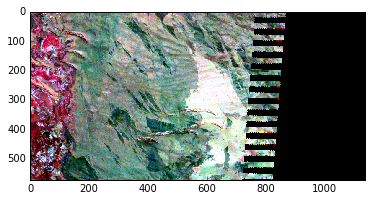

In [25]:
bbox = bboxes[2]
rgb = get_rgb(nbar_ls5, ['nir', 'red', 'green'], '2005-07-01', bbox, 2)
plt.imshow(rgb, interpolation="nearest")

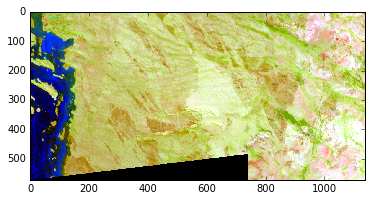

In [26]:
rgb = get_rgb(nbar_ls5, ['swir1', 'nir', 'red'], '2006-03-07', bbox, 2)
plt.imshow(rgb, interpolation='nearest')

Saving the zonal stats dataframe to disk

In [27]:
store = pandas.HDFStore('pilbara-time-series-zonal-stats.h5', 'w', complib='blosc')
store['stats'] = zonal_stats

In [28]:
store.close()